<a href="https://colab.research.google.com/github/MELAI-1/MY-PROJECT/blob/main/nlp/Hate_Speech_Detection_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate Speech Detection using Deep Learning

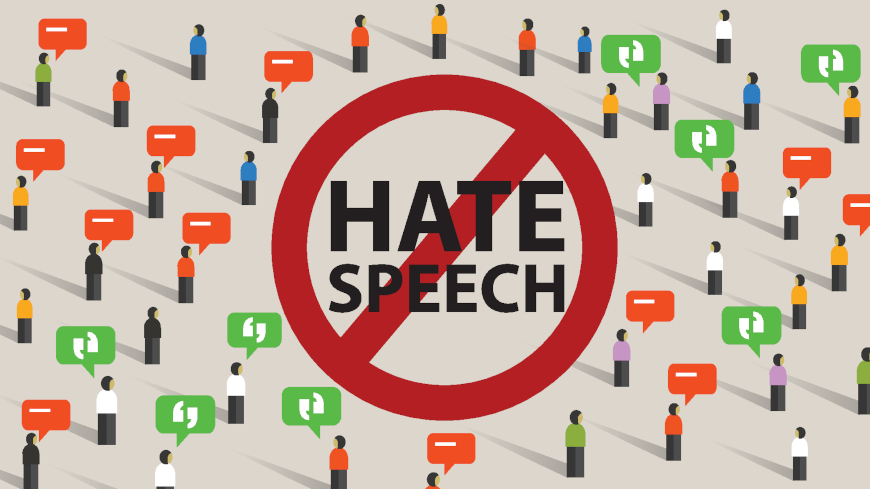

There must be times when you have come across some social media post whose main aim is to spread hate and controversies or use abusive language on social media platforms. As the post consists of textual information to filter out such Hate Speeches NLP comes in handy. This is one of the main applications of NLP which is known as Sentence Classification tasks.

# **Step 1: Importing necessary Libraries**

In [15]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers


from keras.callbacks import EarlyStopping, ReduceLROnPlateau

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

# **Step 2: Loading the Data**

We’ll use the Hate Speech Dataset which contains labeled tweets classified into three categories:

  * 0 - **Hate Speech** : Content explicitly targeting individuals or groups with harmful intent.
  * 1 - **Offensive Language **: Content containing offensive language but not necessarily hate speech.
  * 2 - **Neither** : Neutral content without any offensive or hateful intent.


In [7]:
df = pd.read_csv('/content/Dataset---Hate-Speech-Detection-using-Deep-Learning.csv')
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.shape

(24783, 2)

The dataset contains 24783 tweets with 2 features including:

  * **tweet:** textual content.
  * **class:** label.

Now, let's explore if we have nan value in the dataset

In [4]:
nan_values = df.isnull().sum()
print(nan_values)



class    0
tweet    0
dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


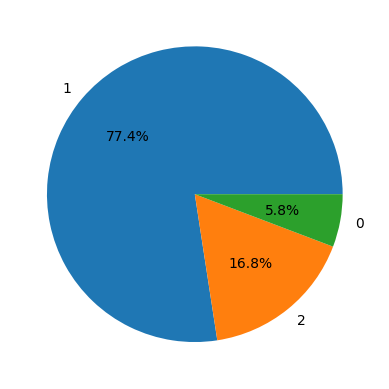

In [9]:
plt.pie(df['class'].value_counts().values,
        labels = df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

# **Step 3:  Balancing the Dataset**

The dataset is imbalanced so we balance it using a combination of upsampling and downsampling

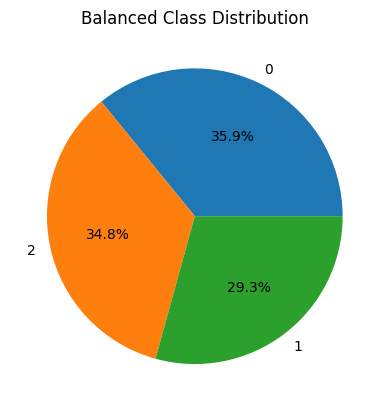

In [10]:
class_0 = df[df['class'] == 0]  # Hate Speech
class_1 = df[df['class'] == 1].sample(n=3500, random_state=42)  # Offensive Language
class_2 = df[df['class'] == 2]  # Neutral

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

# Visualize the balanced distribution
plt.pie(balanced_df['class'].value_counts().values,
        labels=balanced_df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Balanced Class Distribution")
plt.show()

# **Step 4: Text Preprocessing**

Textual data is highly unstructured and need attention on many aspects like:

  * Stopwords Removal
  * Punctuations Removal
  * Stemming or Lemmatization

Although removing data means loss of information but we need to do this to make the data perfect to feed into a machine learning model.

## 1-remove_punctuations

In [11]:
df['tweet'] = df['tweet'].str.lower()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,class,tweet
0,2,rt mayasolovely as a woman you shouldnt compl...
1,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,1,rt cganderson vivabased she look like a tranny
4,1,rt shenikaroberts the shit you hear about me ...


## 2-remove the stop words and Lemmatize the important words.

In [12]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

balanced_df['tweet'] = balanced_df['tweet'].apply(preprocess_text)

**Word cloud** is a text visualization tool that help's us to get insights into the most frequent words present in the corpus of the data.

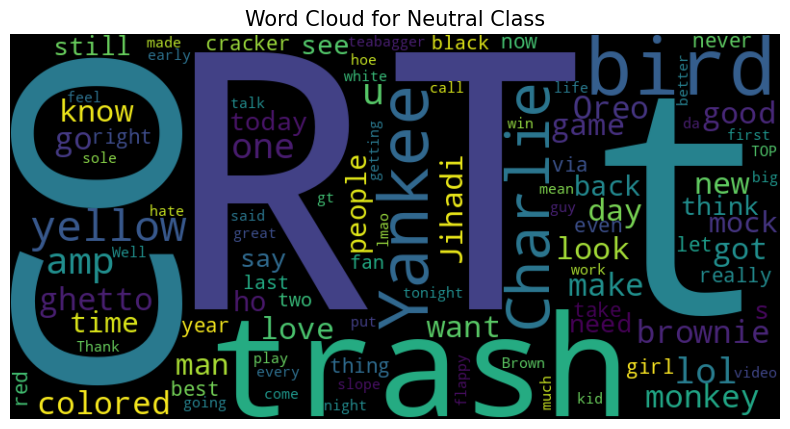

In [13]:
def plot_word_cloud(data, typ):
    corpus = " ".join(data['tweet'])
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {typ} Class", fontsize=15)
    plt.show()

plot_word_cloud(balanced_df[balanced_df['class'] == 2], typ="Neutral")

# **Step 5: Tokenization and Padding**

 In this step we convert text data into numerical sequences and pad them to a fixed length

In [14]:
features = balanced_df['tweet']
target = balanced_df['class']
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# One-hot encode the labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

# **Step 6: Build the Model**

In [16]:
max_words = 10000
max_len = 100

model = keras.models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=(None, max_len))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,755 (1.32 MB)

 Trainable params: 345,731 (1.32 MB)

 Non-trainable params: 1,024 (4.00 KB)

# **Step 7: Training the Model**

### 1-Train the model using callbacks like EarlyStopping and ReduceLROnPlateau.

In [17]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

### 2-Train the model

In [18]:
history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es, lr])

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.6578 - loss: 3.8306 - val_accuracy: 0.5910 - val_loss: 0.9984 - learning_rate: 0.0010
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9105 - loss: 0.3646 - val_accuracy: 0.7767 - val_loss: 0.5893 - learning_rate: 0.0010
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9406 - loss: 0.2537 - val_accuracy: 0.8708 - val_loss: 0.4320 - learning_rate: 0.0010
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.9561 - loss: 0.1956 - val_accuracy: 0.8942 - val_loss: 0.4063 - learning_rate: 0.0010
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9674 - loss: 0.1592 - val_accuracy: 0.8724 - val_loss: 0.5623 - learning_rate: 0.0010
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9676 - loss: 0.1480 - val_accuracy: 0.8034 - val_loss: 0.8530 - learning_rate: 0.0010
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9816 - l

# **Step 8: Evaluating the Model**

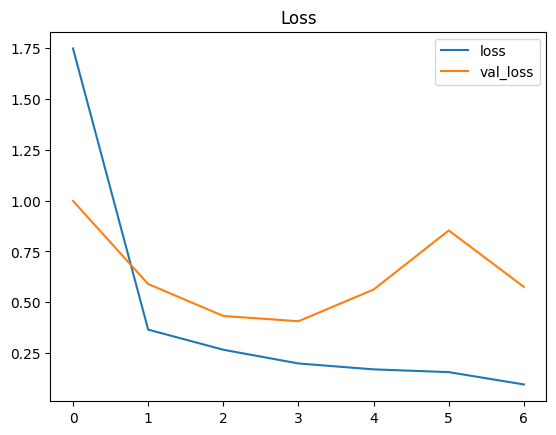

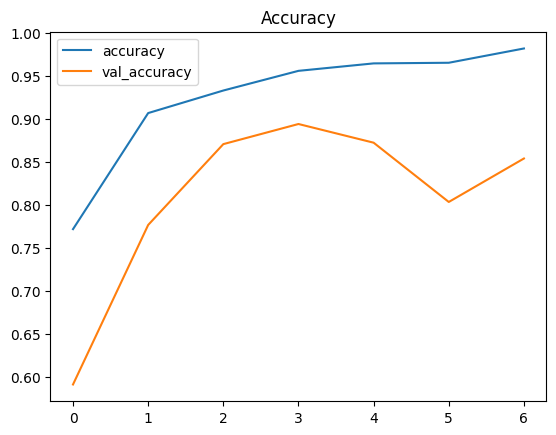

In [19]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(title="Loss")

history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.show()

In [20]:
test_loss, test_acc = model.evaluate(X_val_padded, Y_val)
print(f"Validation Accuracy: {test_acc:.2f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8928 - loss: 0.4040
Validation Accuracy: 0.89
